# Audio Frontend for Xylo-A3 with AGC

In the other notebook (in this folder), we investigated the simulation of modules in the frontend of Xylo-A3, consisting of the PDM microphone.
This corresponds to the first signal path from the analog audio signal until the input of filterbank. We called this module PDM ADC.

In Xylo-A3, we have another signal path which starts from an ordinary microphone and consists of following modules:
- ordinary microphone producing an analog signal
- analog frontend consisting of fixed amplifier + anti-aliasing 1st order low-pass filter.
- AGC (automatic gain controller) module consisting of
  - PGA (programmable gain amplifier) whose gain can be adjusted in the range [1,30] with a 4-bit index control signal, which yields 16 possible gain levels.
  - Equivalent ADC implamented in two steps to eliminate the aliasing noise as much as possible:
    - high-rate ADC: to reduce anti-aliasing noise, the analog signal is sampled with 1, 2, or 4 times target audio sampling rate.
    - anti-aliasing + decimation filter: the resulting high-rate signal is then low-pass filtered and decimated to obtain a 10-bit signal.
  - AGC: output the equ-ADC is forwarded to an AGC module which measures the signal level and if it is low it sends control commands to PGA to increase the amplification gain. Also AGC makes sure that the signal amplification is reduces as soon as signal level goes up to avoid truncating the signal.
  
One can imagine the whole signal path from the output of the microphone until the output of the AGC and an AGC-ADC which quantizes the signal while adjusting its amplitude adaptively.

The output of this module is a 10-bit signal which is zero-padded by 4-bits to yield a 14-bit signal (the same as PDM-ADC), which is then forwarded to the filterbank module.

We already investigated the remaining modules (filterbank + divisive normalization + spike generation) in the other notebook. In this notebook, we will focus on the AGC-ADC.

## AGC Simulation
To see the effect of AGC, we will build a fake audio time-series and will modify its gain to mimic the effect of audio source coming close to or far from the microphone.
Then we will investigate how this signal is processed by the AGC frontend.

This is illustrated in the following siimulation.

Here we assume that the audio source is very close to the microphone at a reference distance of 1m and suddenly it is moved to a distance of 4m.

It is seen from the plots that AGC detects this and slowly adapts the amplitude of the signal by compensating the signal attenuation due to increase in the distance.

/home/saeid/anaconda3/envs/pdm/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Jax was detected. Spike generation can be performed by the JIT compiled version.
__JAX_VERSION__: True: Using Jax-JIT version of spike encoding.


/home/saeid/anaconda3/envs/pdm/lib/python3.8/site-packages/deltasigma/_config.py:54: UserWarning: Cannot find the path for 'cblas.h'. You may set it using the environment variable BLAS_H.
NOTE: You need to pass the path to the directories were the header files are, not the path to the files.
  warn("Cannot find the path for 'cblas.h'. You may set it using the environment variable "
/home/saeid/Projects/Projects/rockpool/rockpool/devices/xylo/xylo_a3/xylo_a3_sim/agc/envelope_controller.py:123: UserWarning: 

+++++++++++++++++++++++++++++++++++++++++++++ WARNING ++++++++++++++++++++++++++++++++++++++++++++++
Number of samples in rise and fall time-constant for envelope controller was set to a power 2 to simplify the implementation!
Please make sure this does not change the AGC performance considerably!

original rise time-constant: 0.0001 sec
current rise time-constant: 0.00016384 sec
window length of the rise window low-pass filter: 8

original fall time-constant: 1.0 sec
current fall t



 ++++++++++++++++++++++++++++++++++++++++++++++ simulating the AGC module +++++++++++++++++++++++++++++++++++++++++++++++ 



100%|██████████| 5859375/5859375 [03:15<00:00, 30043.75it/s]
/tmp/ipykernel_98849/2045855265.py:245: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.draw()
/home/saeid/anaconda3/envs/pdm/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


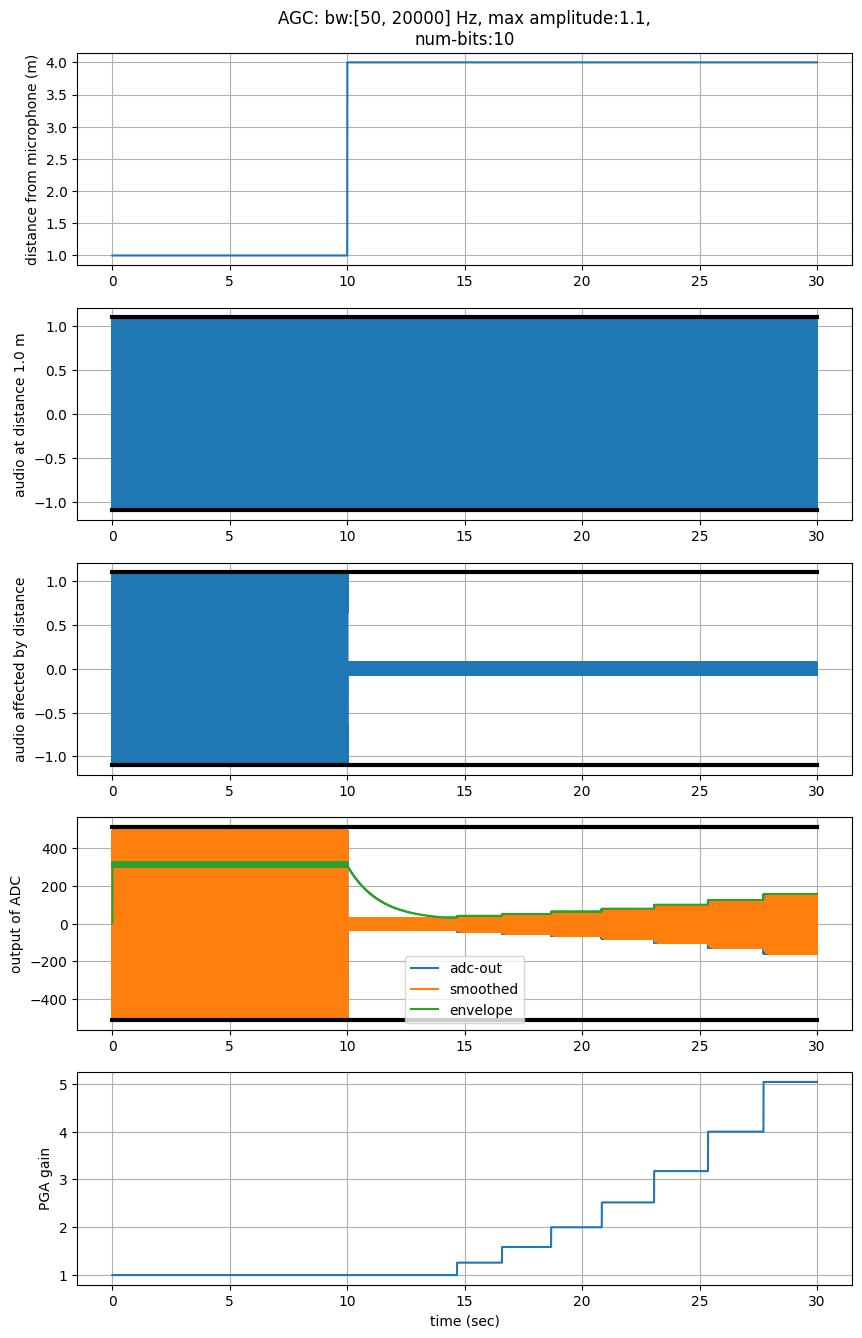

In [1]:
from rockpool.devices.xylo.xylo_a3.xylo_a3_sim.agc.adc import ADC
from rockpool.devices.xylo.xylo_a3.xylo_a3_sim.agc.amplifier import Amplifier
from rockpool.devices.xylo.xylo_a3.xylo_a3_sim.agc.envelope_controller import EnvelopeController
from rockpool.devices.xylo.xylo_a3.xylo_a3_sim.agc.gain_smoother import GainSmootherFPGA
from rockpool.devices.xylo.xylo_a3.xylo_a3_sim.agc.agc_frontend import AGC_ADC

# target audio sampling rate
from rockpool.devices.xylo.xylo_a3.xylo_a3_sim.agc.xylo_a3_agc_specs import AUDIO_SAMPLING_RATE

# analog part parameters
from rockpool.devices.xylo.xylo_a3.xylo_a3_sim.agc.xylo_a3_agc_specs import  XYLO_MAX_AMP, HIGH_PASS_CORNER, LOW_PASS_CORNER

# AGC + gain smoother parameters
from rockpool.devices.xylo.xylo_a3.xylo_a3_sim.agc.xylo_a3_agc_specs import MAX_PGA_GAIN, NUM_BITS_GAIN_QUANTIZATION

from rockpool.timeseries import TSContinuous
import numpy as np

import matplotlib.pyplot as plt


# ================================================
# *       build distance time-series
# ================================================
distance_fs = 4*AUDIO_SAMPLING_RATE
duration = 30
distance_time = np.arange(0, duration, step=1 / distance_fs)

# at ref-distance from microphone the received signal will be rail-to-rail
ref_distance = 1.0

# * Model 2: abrupt movement in front of microphone
distance = ref_distance * np.ones_like(distance_time)
distance[distance_time > duration/3] *= 4

distance_ts = TSContinuous.from_clocked(distance, dt=1 / distance_fs, periodic=True)

# ================================================
# *     build an audio signal
# ================================================
freq = 1000

# original audio signal
audio = XYLO_MAX_AMP * np.sin(2*np.pi*freq*distance_time)

# audio affected by variation of the distance to the microphone
power_attenuation_factor = 4
amplitude_attenuation_factor = power_attenuation_factor/2
audio_modified = audio * (ref_distance / distance**amplitude_attenuation_factor)


# ================================================
# *     build an ADC
# ================================================
num_bits = 10
adc_oversampling_factor = 2     # options: 1, 2, 4 in the current HW design
adc = ADC(
    num_bits=num_bits,
    max_audio_amplitude=XYLO_MAX_AMP,
    oversampling_factor=adc_oversampling_factor,
    fs=AUDIO_SAMPLING_RATE,
)

# =======================================================
# *   build an envelope estimator 
# NOTE: we need to specify two time constants for this depending on how fast we would like the envelope controller
# to respond to signal envelope variations.
#
# We strongly encourage reading the design manual of envelope controller in
# https://spinystellate.office.synsense.ai/saeid.haghighatshoar/agc-for-xylo-v3
#
# `Rule of Thumb`:
# An important parameter is fall_time_constant which specifies if siganl amplitude goes down how fast the reaction time of AGC
# needs to be to adjust/amplify the signal amplitude. 
#
# This typically should be of the order of several seconds so that AGC does not confuse the silent slices of the audio signal
# as attenuated audio.
#
# =======================================================
rise_time_constant = 0.1e-3
fall_time_constant = 1000e-3
num_bits_command = 4

# * set the gain parameters
max_PGA_gain = MAX_PGA_GAIN  # 32 in the current design by the HW team
gain_ratio = max_PGA_gain ** (1 / (2**num_bits_command - 1))

saturation_level = int(min([1 / gain_ratio, 0.6]) * 2 ** (num_bits - 1))

pga_gain_vec = np.asarray([gain_ratio**i for i in range(2**num_bits_command)])

# amplitude thresholds for separating different regions
amplitude_thresholds = (saturation_level / pga_gain_vec[::-1]).astype(np.int64)

# * we designed for a square-root waiting time pattern but for testing we make AGC a little bit faster by decreasing the waiting time slightly
waiting_time_vec = fall_time_constant * np.power(
    np.arange(1, 2**num_bits_command + 1), 1/3
)

max_waiting_time_before_gain_change = np.max(waiting_time_vec)

reliable_max_hysteresis = 5

# * what is the PGA gain index variation specifying the jumps at various regions
# all the other regions are +1 -> increase gain
pga_gain_index_variation = np.ones(2**num_bits_command + 1, dtype=np.int64)

# except for:
pga_gain_index_variation[-1] = -1  # saturation regions
pga_gain_index_variation[-2] = 0  # one level below saturation
pga_gain_index_variation[-3] = 0  # two levels below saturation

# envelope controller
envelope_controller = EnvelopeController(
    num_bits=num_bits,
    amplitude_thresholds=amplitude_thresholds,
    rise_time_constant=rise_time_constant,
    fall_time_constant=fall_time_constant,
    reliable_max_hysteresis=reliable_max_hysteresis,
    waiting_time_vec=waiting_time_vec,
    max_waiting_time_before_gain_change=max_waiting_time_before_gain_change,
    pga_gain_index_variation=pga_gain_index_variation,
    num_bits_command=num_bits_command,
    fs=AUDIO_SAMPLING_RATE,
)


# =======================================================
# *                  build an amplifier
# =======================================================
high_pass_corner = HIGH_PASS_CORNER  # 50 Hz
low_pass_corner = LOW_PASS_CORNER  # 20_000 Hz
fixed_gain_for_PGA_mode = False  # PGA is in AGC mode
amplifier = Amplifier(
    high_pass_corner=high_pass_corner,
    low_pass_corner=low_pass_corner,
    pga_gain_vec=pga_gain_vec,
    settling_time=0.0,
    fixed_gain_for_PGA_mode=fixed_gain_for_PGA_mode,
    fs=distance_fs,
)

# =======================================================
# *          build a gain smoother module
# =======================================================
num_bits_gain_quantization = NUM_BITS_GAIN_QUANTIZATION  # 10 seems to be enough

# minimum waiting time (in seconds) used to set the decay factor of gain smoother
min_waiting_time = envelope_controller.waiting_time_vec.min()

gain_smoother = GainSmootherFPGA(
    num_bits=num_bits,
    min_waiting_time=min_waiting_time,
    num_bits_command=num_bits_command,
    pga_gain_vec=amplifier.pga_gain_vec,
    num_bits_gain_quantization=num_bits_gain_quantization,
    fs=AUDIO_SAMPLING_RATE,
)

# =======================================================
# *       build an ADC with AGC capabilities
# =======================================================
adc_agc = AGC_ADC(
    amplifier=amplifier,
    adc=adc,
    envelope_controller=envelope_controller,
    gain_smoother=gain_smoother,
)


# =======================================================
# *            how to run the simulations
# =======================================================
record = False
progress_report = True

# simulate the system
adc_agc.reset()

# continue
agc_out, state = adc_agc.evolve(
    audio=audio_modified,
    audio_sample_rate=distance_fs,
    record=record,
    progress_report=progress_report,
)

# ===========================================================================
#                         Plot and save the results
# ===========================================================================
plt.figure(figsize=(10, 16))

plt.subplot(511)
plt.plot(distance_time, distance)
plt.ylabel("distance from microphone (m)")
plt.grid(True)
plt.title(
    f"AGC: bw:{[int(amplifier.high_pass_corner), int(amplifier.low_pass_corner)]} Hz, max amplitude:{adc.max_audio_amplitude},\nnum-bits:{adc.num_bits}"
)

plt.subplot(512)
audio_norm = XYLO_MAX_AMP * audio / np.max(np.abs(audio))
plt.plot(np.linspace(0, duration, len(audio_norm)), audio_norm)
plt.plot([0, duration], [XYLO_MAX_AMP, XYLO_MAX_AMP], "k", linewidth=3)
plt.plot([0, duration], [-XYLO_MAX_AMP, -XYLO_MAX_AMP], "k", linewidth=3)
plt.grid(True)
plt.ylabel(f"audio at distance {ref_distance} m")

plt.subplot(513)
plt.plot(np.linspace(0, duration, len(audio_modified)), audio_modified)
plt.plot([0, duration], [XYLO_MAX_AMP, XYLO_MAX_AMP], "k", linewidth=3)
plt.plot([0, duration], [-XYLO_MAX_AMP, -XYLO_MAX_AMP], "k", linewidth=3)
plt.grid(True)
plt.ylabel("audio affected by distance")

plt.subplot(514)
max_adc_val = 2 ** (adc.num_bits - 1) - 1
min_adc_val = -max_adc_val

plt.plot(np.linspace(0, duration, len(state["adc_output"])), state["adc_output"], label="adc-out")
plt.plot(
    np.linspace(0, duration, len(state["gain_smoother_output"])),
    state["gain_smoother_output"],
    label="smoothed",
)
plt.plot(
    np.linspace(0, duration, len(state["envelope"])),
    state["envelope"],
    label="envelope",
)
plt.plot([0, duration], [max_adc_val, max_adc_val], "k", linewidth=3)
plt.plot([0, duration], [min_adc_val, min_adc_val], "k", linewidth=3)
plt.legend()
plt.grid(True)
plt.ylabel("output of ADC")

plt.subplot(515)
plt.plot(
    np.linspace(0, duration, len(state["agc_pga_gain"])), state["agc_pga_gain"]
)
plt.grid(True)
plt.ylabel("PGA gain")

plt.xlabel("time (sec)")
plt.draw()

plt.show()


--- 

## Effect of Gain Smoother
By focusing at the plots at PGA gain transition times, we can see that the output of internal ADC undergoes jumps due to jumps in the gain of PGA at those points.
However, gain smoother corrects these jumps and allows a smooth transition of signal at those points.

This is more important at high signal amplitues and avoids introducing nonlinear distortion due to signal jumps.

In our design we make sure that the gain smoothing reaches its steady-state before the next gain change happens in PGA. 
The parameter that controls this is  `min_waiting_time`: the time constant of the gain smoothing filter is set to `min_waiting_time / 5`.



(-150.0, 150.0)

/home/saeid/anaconda3/envs/pdm/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


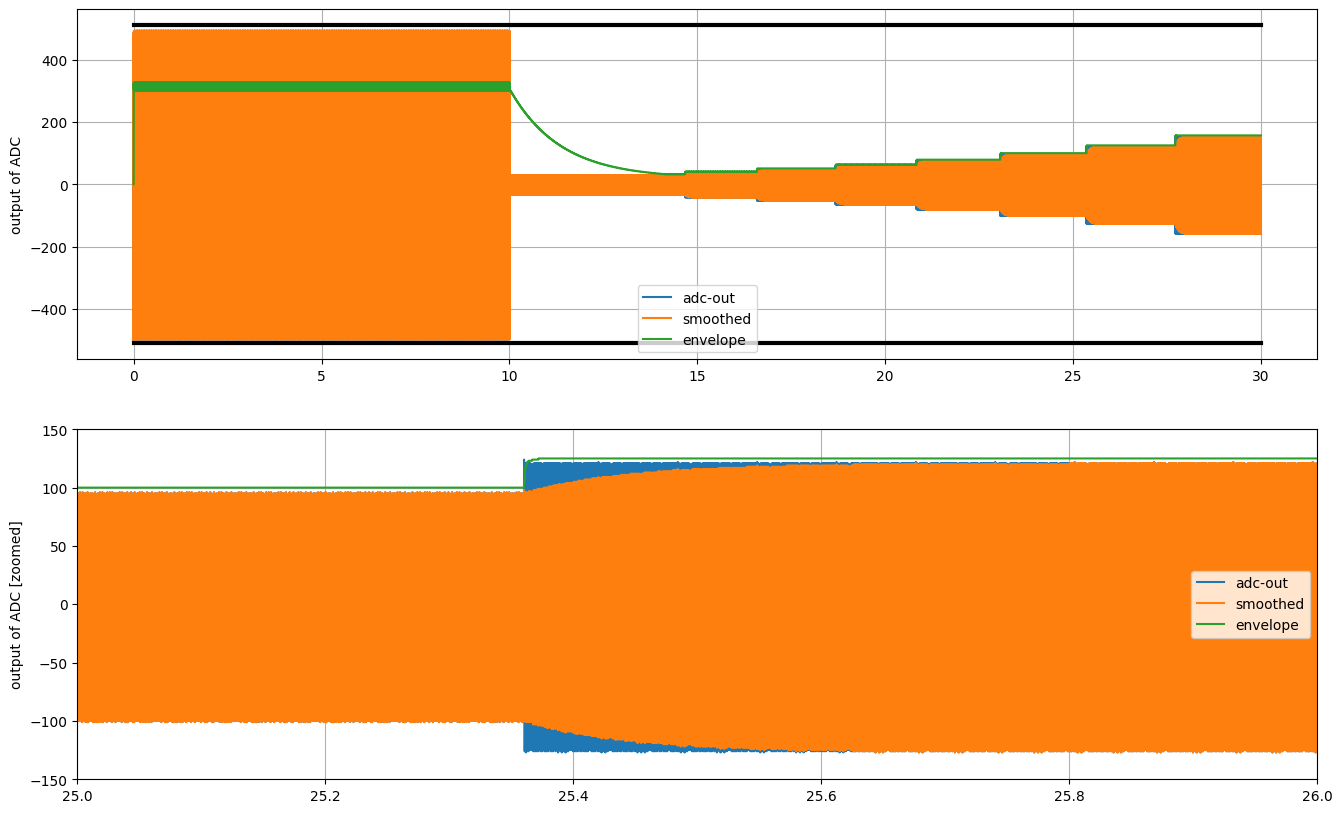

In [3]:
max_adc_val = 2 ** (adc.num_bits - 1) - 1
min_adc_val = -max_adc_val

plt.figure(figsize=(16,10))

plt.subplot(211)
plt.plot(np.linspace(0, duration, len(state["adc_output"])), state["adc_output"], label="adc-out")
plt.plot(
    np.linspace(0, duration, len(state["gain_smoother_output"])),
    state["gain_smoother_output"],
    label="smoothed",
)
plt.plot(
    np.linspace(0, duration, len(state["envelope"])),
    state["envelope"],
    label="envelope",
)
plt.plot([0, duration], [max_adc_val, max_adc_val], "k", linewidth=3)
plt.plot([0, duration], [min_adc_val, min_adc_val], "k", linewidth=3)
plt.legend()
plt.grid(True)
plt.ylabel("output of ADC")


plt.subplot(212)
plt.plot(np.linspace(0, duration, len(state["adc_output"])), state["adc_output"], label="adc-out")
plt.plot(
    np.linspace(0, duration, len(state["gain_smoother_output"])),
    state["gain_smoother_output"],
    label="smoothed",
)
plt.plot(
    np.linspace(0, duration, len(state["envelope"])),
    state["envelope"],
    label="envelope",
)
plt.plot([0, duration], [max_adc_val, max_adc_val], "k", linewidth=3)
plt.plot([0, duration], [min_adc_val, min_adc_val], "k", linewidth=3)
plt.legend()
plt.grid(True)
plt.ylabel("output of ADC [zoomed]")

plt.xlim([25, 26])
plt.ylim([-150, 150])




